#TP03
Utilizar otro dataset y poner en práctica la predicción de próxima palabra

# 1- Carga de la data

In [25]:
import random
import io
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
!pip install gradio --quiet


In [26]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py


In [27]:
from torch_helpers import categorical_acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = categorical_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_data, valid_target = iter(valid_loader).next()
        output = model(valid_data)

        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = categorical_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

In [28]:
# Leer el archivo JSONL
data = pd.read_json("hf://datasets/LDJnr/Puffin/Puffin.jsonl", lines=True)
data = data.drop('id', axis=1)

# Crear una lista para almacenar las nuevas filas
rows = []

# Supongamos que la columna que contiene las conversaciones se llama 'conversations'
for conversation in data['conversations']:  # Cambia esto si es necesario
    for turn in conversation:
        rows.append({
            'from': turn['from'],
            'value': turn['value']
        })

# Crear un nuevo DataFrame con las filas transformadas
transformed_data = pd.DataFrame(rows)

# Crear dos DataFrames separados
human_data = transformed_data[transformed_data['from'] == 'human'].reset_index(drop=True)
gpt_data = transformed_data[transformed_data['from'] == 'gpt'].reset_index(drop=True)

# Eliminar la columna 'from' de ambos DataFrames
human_data = human_data.drop(columns=['from'])
gpt_data = gpt_data.drop(columns=['from'])

# Mostrar las primeras filas de cada DataFrame
print("Human Data:")
print(human_data.head())

print("\nGPT Data:")
print(gpt_data.head())



Human Data:
                                               value
0  How do I center a text element vertically in a...
1   Add some spacing between the text and the button
2  Instead of using a spacer how do I give some p...
3  How does the regulation of glycolysis allow fo...
4  "How does the placement of the feet and positi...

GPT Data:
                                               value
0  In Jetpack Compose, you can center a text elem...
1  To add spacing between the `Text` and `Button`...
2  You can add padding to the `Text` element by u...
3  The regulation of glycolysis is essential for ...
4  The placement of the feet and positioning of t...


In [29]:
from torch_helpers import Tokenizer # tool de keras equivalente a ltokenizer de nltk
from torch_helpers import text_to_word_sequence # tool de keras equivalente a word_teokenize de nltk
from torch_helpers import pad_sequences # tool de keras qye se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [30]:
# Ejemplo de como transformar una oración a tokens usando keras
text = human_data.loc[0, 'value']
text

'How do I center a text element vertically in a row in jetpack compose? The height of the row is determined by a button next to the text element.'

In [31]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['how',
 'do',
 'i',
 'center',
 'a',
 'text',
 'element',
 'vertically',
 'in',
 'a',
 'row',
 'in',
 'jetpack',
 'compose',
 'the',
 'height',
 'of',
 'the',
 'row',
 'is',
 'determined',
 'by',
 'a',
 'button',
 'next',
 'to',
 'the',
 'text',
 'element']

In [32]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in human_data[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

# Demos un vistazo
sentence_tokens[:2]

<ipython-input-32-35becea80cfd>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sentence_tokens.append(text_to_word_sequence(row[0]))


[['how',
  'do',
  'i',
  'center',
  'a',
  'text',
  'element',
  'vertically',
  'in',
  'a',
  'row',
  'in',
  'jetpack',
  'compose',
  'the',
  'height',
  'of',
  'the',
  'row',
  'is',
  'determined',
  'by',
  'a',
  'button',
  'next',
  'to',
  'the',
  'text',
  'element'],
 ['add', 'some', 'spacing', 'between', 'the', 'text', 'and', 'the', 'button']]

In [33]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [34]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
# seq_input + output
text_sequences


[['how', 'do', 'i', 'center'],
 ['do', 'i', 'center', 'a'],
 ['i', 'center', 'a', 'text'],
 ['center', 'a', 'text', 'element'],
 ['a', 'text', 'element', 'vertically'],
 ['text', 'element', 'vertically', 'in'],
 ['element', 'vertically', 'in', 'a'],
 ['vertically', 'in', 'a', 'row'],
 ['in', 'a', 'row', 'in'],
 ['a', 'row', 'in', 'jetpack'],
 ['row', 'in', 'jetpack', 'compose'],
 ['in', 'jetpack', 'compose', 'the'],
 ['jetpack', 'compose', 'the', 'height'],
 ['compose', 'the', 'height', 'of'],
 ['the', 'height', 'of', 'the'],
 ['height', 'of', 'the', 'row'],
 ['of', 'the', 'row', 'is'],
 ['the', 'row', 'is', 'determined'],
 ['row', 'is', 'determined', 'by'],
 ['is', 'determined', 'by', 'a'],
 ['determined', 'by', 'a', 'button'],
 ['by', 'a', 'button', 'next'],
 ['a', 'button', 'next', 'to'],
 ['button', 'next', 'to', 'the'],
 ['next', 'to', 'the', 'text']]

In [35]:
tok = Tokenizer()

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [36]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[21, 20, 18, 6],
 [20, 18, 6, 1],
 [18, 6, 1, 5],
 [6, 1, 5, 7],
 [1, 5, 7, 8],
 [5, 7, 8, 3],
 [7, 8, 3, 1],
 [8, 3, 1, 4],
 [3, 1, 4, 3],
 [1, 4, 3, 9],
 [4, 3, 9, 10],
 [3, 9, 10, 2],
 [9, 10, 2, 11],
 [10, 2, 11, 12],
 [2, 11, 12, 2],
 [11, 12, 2, 4],
 [12, 2, 4, 13],
 [2, 4, 13, 14],
 [4, 13, 14, 15],
 [13, 14, 15, 1],
 [14, 15, 1, 16],
 [15, 1, 16, 17],
 [1, 16, 17, 19],
 [16, 17, 19, 2],
 [17, 19, 2, 5]]

In [37]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'a': 1, 'the': 2, 'in': 3, 'row': 4, 'text': 5, 'center': 6, 'element': 7, 'vertically': 8, 'jetpack': 9, 'compose': 10, 'height': 11, 'of': 12, 'is': 13, 'determined': 14, 'by': 15, 'button': 16, 'next': 17, 'i': 18, 'to': 19, 'do': 20, 'how': 21}


In [38]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'do': 2, 'how': 1, 'center': 4, 'i': 3, 'a': 12, 'text': 5, 'element': 4, 'vertically': 4, 'in': 7, 'row': 8, 'jetpack': 4, 'compose': 4, 'the': 9, 'height': 4, 'of': 4, 'is': 4, 'determined': 4, 'by': 4, 'button': 4, 'next': 4, 'to': 3})


#2 - Preprocesamiento completo

In [14]:
# Vistazo a las primeras filas
human_data.loc[:15,'value']

,value
0,How do I center a text element vertically in a...
1,Add some spacing between the text and the button
2,Instead of using a spacer how do I give some p...
3,How does the regulation of glycolysis allow fo...
4,"""How does the placement of the feet and positi..."
5,pretend you are a union leader preparing for t...
6,what are the detailed elements of your bargain...
7,create sample proposal language for the plan a...
8,develop a company response to the above
9,What are the key steps involved in creating a ...


In [15]:
# Concatenamos todos los rows en un solo valor
corpus = human_data.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

<ipython-input-15-ec906088e784>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  corpus = human_data.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]


'How do I center a text element vertically in a row in jetpack compose? The height of the row is determined by a button next to the text element. Add some spacing between the text and the button Instead of using a spacer how do I give some padding to the text element instead? How does the regulation of glycolysis allow for efficient energy production in the human body? "How does the placement of the feet and positioning of the center of gravity affect balance and stability during various physical activities, such as walking or standing on one leg?" pretend you are a union leader preparing for the renewal of your collective bargaining agreement - how do you prepare? what are the detailed elements of your bargaining strategy listed. please list with bullet points create sample proposal language for the plan above develop a company response to the above What are the key steps involved in creating a new vaccine for emerging infectious diseases using biotechnology, and how can these steps b

In [16]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)

In [17]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 423736


In [18]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [19]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['how', 'do', 'i', 'center'],
 ['do', 'i', 'center', 'a'],
 ['i', 'center', 'a', 'text'],
 ['center', 'a', 'text', 'element'],
 ['a', 'text', 'element', 'vertically'],
 ['text', 'element', 'vertically', 'in'],
 ['element', 'vertically', 'in', 'a'],
 ['vertically', 'in', 'a', 'row'],
 ['in', 'a', 'row', 'in'],
 ['a', 'row', 'in', 'jetpack'],
 ['row', 'in', 'jetpack', 'compose'],
 ['in', 'jetpack', 'compose', 'the'],
 ['jetpack', 'compose', 'the', 'height'],
 ['compose', 'the', 'height', 'of'],
 ['the', 'height', 'of', 'the'],
 ['height', 'of', 'the', 'row'],
 ['of', 'the', 'row', 'is'],
 ['the', 'row', 'is', 'determined'],
 ['row', 'is', 'determined', 'by'],
 ['is', 'determined', 'by', 'a']]

In [20]:
# Proceso de tokenizacion
tok = Tokenizer()
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[26, 36, 11, 644],
 [36, 11, 644, 4],
 [11, 644, 4, 148],
 [644, 4, 148, 1067],
 [4, 148, 1067, 6776],
 [148, 1067, 6776, 6],
 [1067, 6776, 6, 4],
 [6776, 6, 4, 446],
 [6, 4, 446, 6],
 [4, 446, 6, 9216],
 [446, 6, 9216, 4584],
 [6, 9216, 4584, 1],
 [9216, 4584, 1, 778],
 [4584, 1, 778, 5],
 [1, 778, 5, 1],
 [778, 5, 1, 446],
 [5, 1, 446, 7],
 [1, 446, 7, 1551],
 [446, 7, 1551, 35],
 [7, 1551, 35, 4]]

In [22]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 423732


#3 - Input y target

In [21]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [39]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [40]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [41]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(25, 3)
(25,)


In [42]:
# Palabras del vocabulario
tok.index_word

{1: 'a',
 2: 'the',
 3: 'in',
 4: 'row',
 5: 'text',
 6: 'center',
 7: 'element',
 8: 'vertically',
 9: 'jetpack',
 10: 'compose',
 11: 'height',
 12: 'of',
 13: 'is',
 14: 'determined',
 15: 'by',
 16: 'button',
 17: 'next',
 18: 'i',
 19: 'to',
 20: 'do',
 21: 'how'}

In [43]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size


21

In [44]:
# ¡Ojo! y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [45]:
# Hay que restar 1
y_data_int_offset = y_data_int - 1
min(y_data_int_offset)

0

In [46]:
# Definir la clase Data que hereda de Dataset
class Data(Dataset):
    def __init__(self, x, y, vocab_size):
        # Convertir los arrays de numpy a tensores.
        # PyTorch espera en general entradas de 32 bits
        self.x = torch.from_numpy(x.astype(np.int32))

        # Transformar los datos de salida a codificación one-hot
        # La función de pérdida espera la salida en formato float
        self.y = F.one_hot(torch.from_numpy(y), num_classes=vocab_size).float()

        # Almacenar la longitud del conjunto de datos
        self.len = self.y.shape[0]

    # Definir cómo obtener un elemento por índice
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # Definir el tamaño del conjunto de datos
    def __len__(self):
        return self.len

# Crear el conjunto de datos (asegúrate de definir x_data, y_data_int_offset y vocab_size antes de esta línea)
data_set = Data(x_data, y_data_int_offset, vocab_size)

# Obtener el tamaño de entrada (número de características de entrada)
input_size = data_set.x.shape[1]
print("input_size:", input_size)

# Obtener la dimensión de salida (número de clases)
output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

input_size: 3
Output dim 21


In [47]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

Tamaño del conjunto de entrenamiento: 20
Tamaño del conjunto de validacion: 5


#4 - Entrenar el modelo

In [48]:
class Model1(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size --> 1628 palabras distintas + 1 para padding o UNK
        # embedding_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable)
        self.lstm_size = 64
        self.num_layers = 2
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=5, padding_idx=0)
        self.lstm1 = nn.LSTM(input_size=5, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=32) # Fully connected layer
        self.fc2 = nn.Linear(in_features=32, out_features=output_dim) # Fully connected layer

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state=None):
        if prev_state is None:
            # En cada nueva inferencia reinicio el hidden state
            # de la LSTM al menos que sea pasado por parámetro el
            # elstado de previo
            # Esta acción se realiza especialmente para que
            # el hidden_state de la última inferencia no afecte
            # a la siguiente
            batch_size = x.shape[0] #(batch, seq_size)
            prev_state = self.init_hidden(batch_size)

        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out, prev_state)
        out = self.relu(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.softmax(self.fc2(out))
        return out

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size),
                torch.zeros(self.num_layers, batch_size, self.lstm_size))

model1 = Model1(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
model1_criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model1, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))

# otra posibilidad
#summary(model1, input_data=data_set[0][0].unsqueeze(0))

Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 21]                   --
├─Embedding: 1-1                         [1, 3, 5]                 110
├─LSTM: 1-2                              [1, 3, 64]                51,456
├─Linear: 1-3                            [1, 32]                   2,080
├─ReLU: 1-4                              [1, 32]                   --
├─Linear: 1-5                            [1, 21]                   693
├─Softmax: 1-6                           [1, 21]                   --
Total params: 54,339
Trainable params: 54,339
Non-trainable params: 0
Total mult-adds (M): 0.16
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.22
Estimated Total Size (MB): 0.22

In [49]:
def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento
    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = categorical_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_data, valid_target = next(iter(valid_loader))  # Actualización aquí
        output = model(valid_data)

        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = categorical_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history


In [50]:
history1 = train(model1,
                train_loader,
                valid_loader,
                model1_optimizer,
                model1_criterion,
                epochs=100
                )

Epoch: 1/100 - Train loss 3.046 - Train accuracy 0.100 - Valid Loss 3.043 - Valid accuracy 0.200
Epoch: 2/100 - Train loss 3.046 - Train accuracy 0.100 - Valid Loss 3.044 - Valid accuracy 0.200
Epoch: 3/100 - Train loss 3.045 - Train accuracy 0.100 - Valid Loss 3.044 - Valid accuracy 0.200
Epoch: 4/100 - Train loss 3.045 - Train accuracy 0.100 - Valid Loss 3.044 - Valid accuracy 0.200
Epoch: 5/100 - Train loss 3.045 - Train accuracy 0.100 - Valid Loss 3.044 - Valid accuracy 0.200
Epoch: 6/100 - Train loss 3.045 - Train accuracy 0.100 - Valid Loss 3.044 - Valid accuracy 0.200
Epoch: 7/100 - Train loss 3.045 - Train accuracy 0.100 - Valid Loss 3.044 - Valid accuracy 0.200
Epoch: 8/100 - Train loss 3.045 - Train accuracy 0.100 - Valid Loss 3.044 - Valid accuracy 0.200
Epoch: 9/100 - Train loss 3.045 - Train accuracy 0.100 - Valid Loss 3.044 - Valid accuracy 0.200
Epoch: 10/100 - Train loss 3.044 - Train accuracy 0.100 - Valid Loss 3.044 - Valid accuracy 0.200
Epoch: 11/100 - Train loss 3.

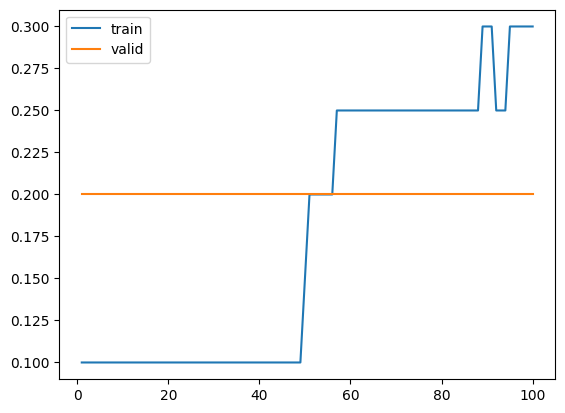

In [51]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

#5 - Predicción de próxima palabra


In [52]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [53]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')

    # Transformo a tensor
    tensor = torch.from_numpy(encoded.astype(np.int32))

    # Predicción softmax
    y_hat = model1(tensor).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
  )

iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://924faa5a728b02abd8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://924faa5a728b02abd8.gradio.live


In [54]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

        # Transformo a tensor
        tensor = torch.from_numpy(encoded.astype(np.int32))

        # Predicción softmax
        y_hat = model1(tensor).argmax(axis=-1)

		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text


In [55]:
input_text='hello'

generate_seq(model1, tok, input_text, max_length=3, n_words=2)

'hello a in'

⏰

Referencias:
* https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/blob/main/clase_4/jupyter_notebooks/pytorch/4d%20-%20predicci%C3%B3n_palabra.ipynb

